# Identifying sources

`opticam_new` uses `photutils` to find sources in images. This notebook will demonstrate how to define source finders for use with `opticam_new`, as well as explain `opticam_new`'s default behaviour when no source finder is specified.

## Test Image

First thing's first, let's open an image that contains some sources. For this example, I'll use one of the images from the [Basic Usage tutorial](basic_usage.ipynb):

In [1]:
import opticam_new

opticam_new.generate_observations(
    out_dir='finders_tutorial/data',
    n_images=20,
    circular_aperture=False,
    )

[OPTICAM] variable source is at (122, 104)


Generating observations: 100%|██████████|[00:04<00:00]


In [2]:
from astropy.io import fits
import numpy as np
import os

files = os.listdir("finders_tutorial/data")
file = files[0]

with fits.open(f"finders_tutorial/data/{file}") as hdul:
    print(repr(hdul[0].header))
    image = np.array(hdul[0].data)
    binning_factor = int(hdul[0].header['BINNING'][0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
FILTER  = 'i       '                                                            
BINNING = '4x4     '                                                            
GAIN    =                  1.0                                                  
UT      = '2024-01-01 00:00:12'                                                 


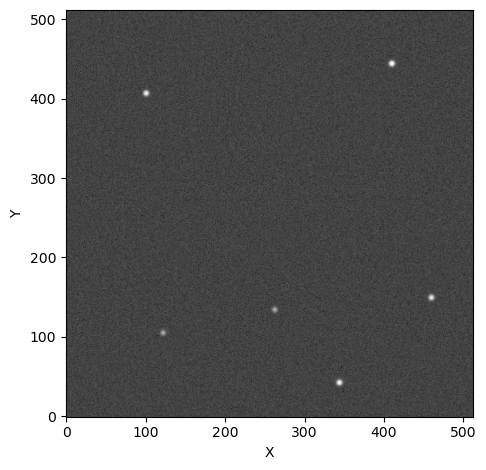

In [3]:
from astropy.visualization import simple_norm
from matplotlib import pyplot as plt

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r")

ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

## Default Finder

`opticam_new` implements two default source finders: `Finder` (default) and `CrowdedFinder` (better for crowded fields, but more expensive). `Finder` does not implement any source deblending, while `CrowdedFinder` does. Both of these source finders are wrappers for `photutils.segmentation.SourceFinder` with some added convenience tailored to OPTICAM.

Let's use `opticam_new.Finder` to identify the sources in the above image:

In [4]:
from opticam_new import DefaultFinder

from photutils.segmentation import detect_threshold

# default value for npixels is 128 // binning_factor**2
# default value for border_width is 1/16th of the image width
default_finder = DefaultFinder(npixels=128 // 4**2, border_width=image.shape[0] // 16)

default_segm = default_finder(image, threshold=detect_threshold(image, nsigma=5))  # detect sources above 5 sigma
print(type(default_segm))

<class 'photutils.segmentation.core.SegmentationImage'>


When calling a `DefaultFinder()` instance, a [`SegmentationImage`](https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html) is returned. This can be used to define a `SourceCatalog`:

In [5]:
from photutils.segmentation import SourceCatalog

tbl = SourceCatalog(data=image, segment_img=default_segm).to_table()

print(tbl)

label     xcentroid          ycentroid      ...     kron_flux     kron_fluxerr
                                            ...                               
----- ------------------ ------------------ ... ----------------- ------------
    1 343.50869723873694 42.920775668063335 ... 97240.28273022271          nan
    2 121.71262540499553  105.5502562842776 ...  84251.0093768113          nan
    3 262.07427576900153 134.55645675772124 ... 81260.76519898814          nan
    4  459.1601803809478  149.7953651395983 ... 94897.71701537866          nan
    5 100.36621469873283 406.86369869058916 ... 92466.82927165771          nan
    6  409.5092033513822  444.2089681224758 ... 98622.62071081837          nan


This is how catalogs are defined in `opticam_new`. We can also plot the `SegmentationImage` directly to see the sources:

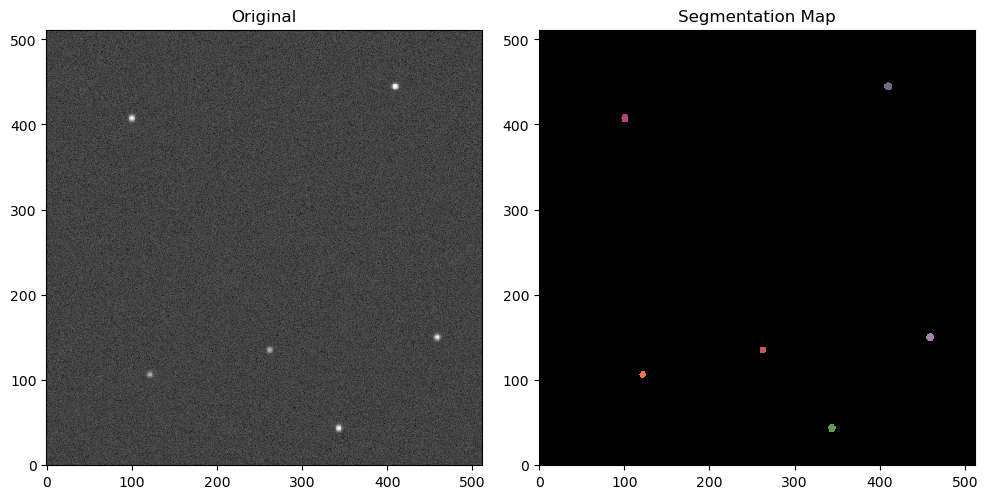

In [6]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(default_segm, origin="lower", cmap=default_segm.cmap, interpolation="nearest")

plt.show()

As we can see, all the sources have been correctly identified.

## Custom Source Finders

### Defining the Source Finder

Let's now define a custom source finder. Custom source finders must define a `__call__()` method that takes two parameters: `image` and `threshold`, and returns a `SegmentationImage`. `image` should be an `NDArray` containing the image data. `threshold` defines the threshold for source detection, typically defined in units of the background RMS:

In [7]:
from photutils.segmentation import SourceFinder

class CustomFinder:
    
    def __init__(self, border_width = 0, **kwargs):
        
        self.border_width = border_width
        
        self.finder = SourceFinder(**kwargs)
    
    def __call__(self, image, threshold):
        
        segment_map = self.finder(image, threshold)
        segment_map.remove_border_labels(border_width=self.border_width, relabel=True)
        
        return segment_map

This source finder is basically a wrapper for the `SourceFinder` class from `photutils` with an additional `border_width` parameter. It implements a custom `__call__()` method that identifies sources and removes source labels close to the edge of the image, just like `opticam_new.DefaultFinder`. Let's initialise this custom source finder and use it to identify sources in the above image. We'll set the `npixels` and `border_width` parameters to the same values assumed by `opticam_new.DefaultFinder`, but set some custom values for the other parameters:

In [8]:
custom_finder = CustomFinder(npixels=128 // 4**2, border_width=image.shape[0] // 16, deblend=True,
                             nlevels=256, contrast=0, progress_bar=False)

custom_segm = custom_finder(image, threshold=detect_threshold(image, nsigma=5))

Let's plot the image to see what it looks like:

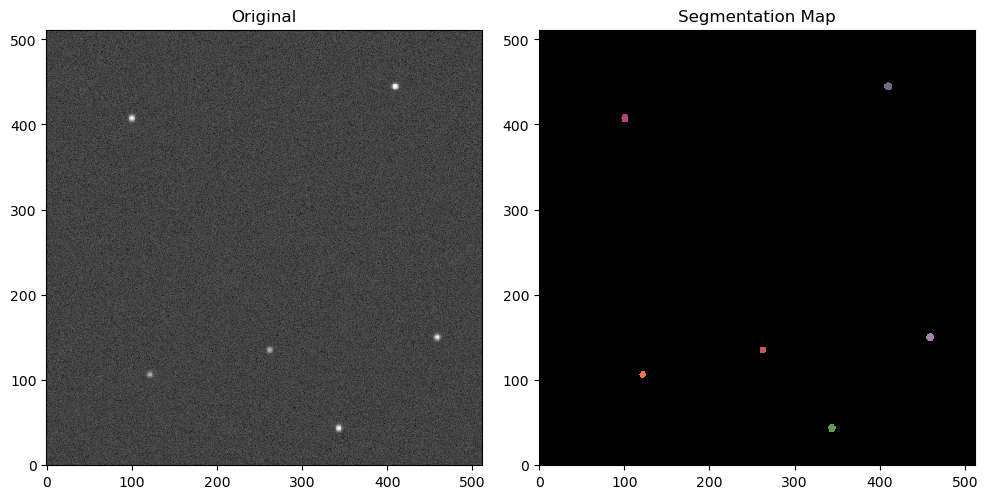

In [9]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10, 5))

axs[0].set_title("Original")
axs[0].imshow(image, norm=simple_norm(image, stretch="sqrt"), origin="lower", cmap="Greys_r", interpolation='nearest')

axs[1].set_title("Segmentation Map")
axs[1].imshow(custom_segm, origin="lower", cmap=custom_segm.cmap, interpolation="nearest")

plt.show()

As we can see, we have once again recovered all six sources. We could also pass our custom source finder to `opticam_new.Catalog`:

[OPTICAM] finders_tutorial/results not found, attempting to create ...
[OPTICAM] finders_tutorial/results created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]

[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


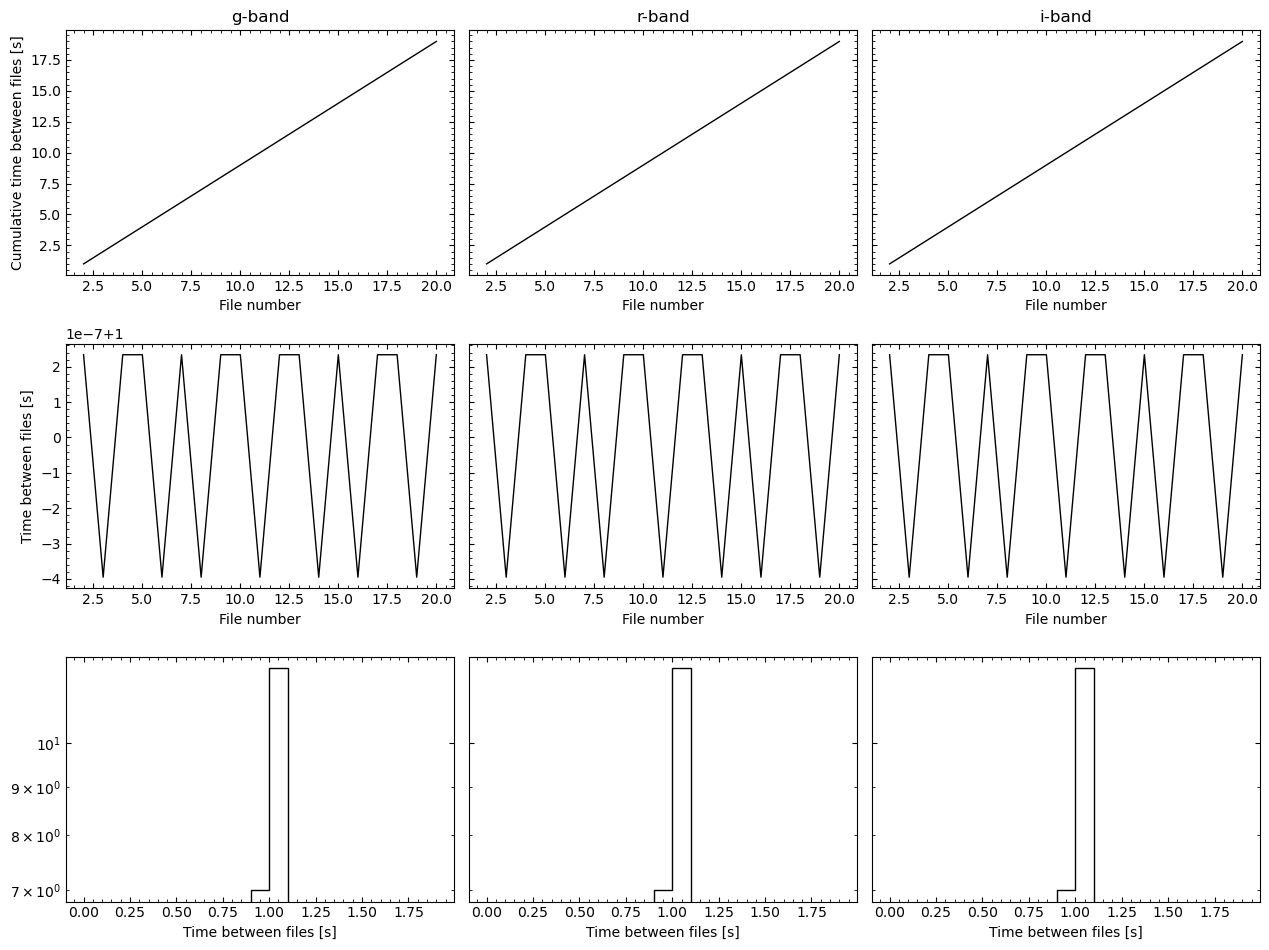

In [10]:
cat = opticam_new.Catalog(
    out_directory='finders_tutorial/results',
    data_directory='finders_tutorial/data',
    finder=custom_finder,
    remove_cosmic_rays=False,
)

[OPTICAM] Initialising catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


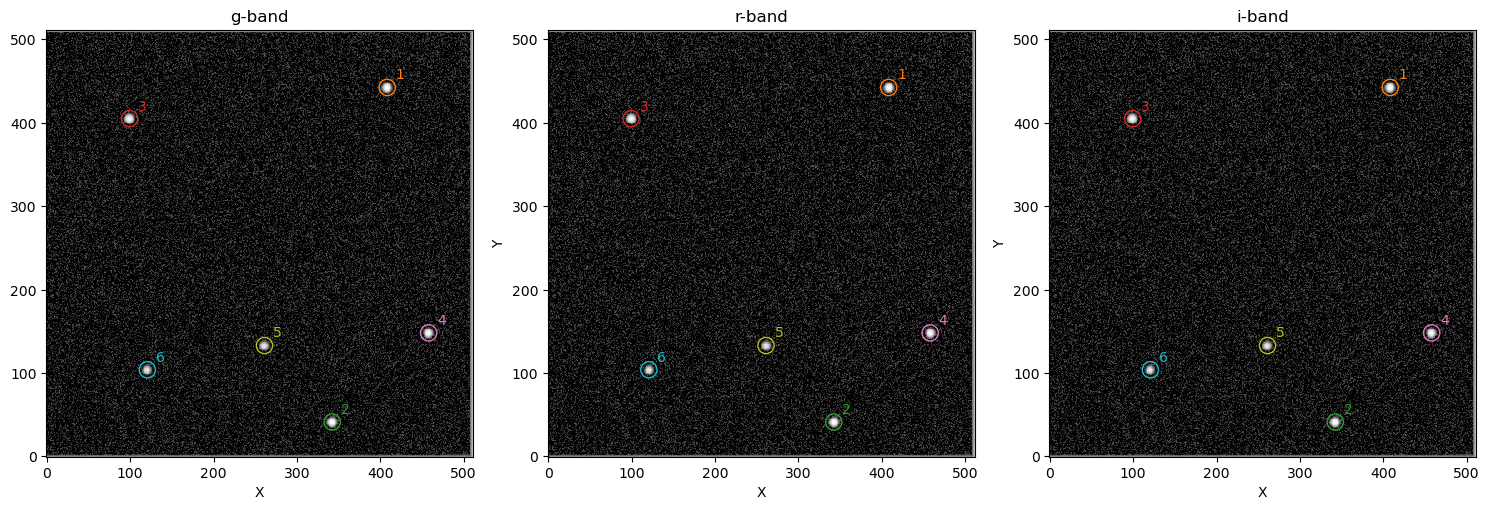

In [11]:
cat.create_catalogs()

Once again, we have successfully identified all six sources. Admittedly, this rather simple example does a poor job of demonstrating why defining a custom source finder may be useful, but hopefully it is clear how custom source finders can be implemented. For more information on defining custom source finders, I refer to the excellent `photutils` documentation: https://photutils.readthedocs.io/en/stable/user_guide/segmentation.html.

That concludes the source finder tutorial for `opticam_new`!